Read header and print it

In [2]:
from flopa.io.ptuio.reader import TTTRReader

reader = TTTRReader('../test_data/B16par_10.ptu')
for key, value in reader.header.tags.items():
    print(f'{key}: {value}')

Measurement_SubMode = reader.header.tags.get("Measurement_SubMode")

if Measurement_SubMode<1:
    print("Not an image. You must set scanning configuration.")
else:
    ImgHdr_PixX = reader.header.tags.get("ImgHdr_PixX")
    ImgHdr_PixY = reader.header.tags.get("ImgHdr_PixY")

# This file is recorded in point mode - scanner information is not in the header, but the markers are recorded anyway

File_GUID: {73B5FD1C-F638-4101-B210-38865186386C}
File_CreatingTime: 2024-10-23 11:18:12.320000
Measurement_SubMode: 0
File_Comment: 1024x1024px, 
bi-di
dwell 2.06us
16 line avg
3 frames
zoom 1.5
40x WI
pwr 9% (12mW)
TTResult_StopReason: 1
Fast_Load_End: <Empty>
CreatorSW_Name: SymPhoTime 64
CreatorSW_Version: 2.7
CreatorSW_SVNBuild: 5615
CreatorSW_Modules: 0
ImgHdr_Dimensions: 1
ImgHdr_Ident: 3
Measurement_Mode: 3
HW_Type: HydraHarp
HW_SerialNo: 1027371
HW_Version: 2.0
HW_ExternalRefClock: False
HW_Modules: 4
HWModule_TypeCode[0]: 1000
HWModule_VersCode[0]: 51052545
HWModule_TypeCode[1]: 1010
HWModule_VersCode[1]: 33554954
HWModule_TypeCode[2]: 1040
HWModule_VersCode[2]: 18153994
HWModule_TypeCode[3]: 1040
HWModule_VersCode[3]: 18153994
HW_Markers: 4
HWMarkers_Enabled[0]: True
HWMarkers_RisingEdge[0]: False
HWMarkers_Enabled[1]: True
HWMarkers_RisingEdge[1]: True
HWMarkers_Enabled[2]: True
HWMarkers_RisingEdge[2]: False
HWMarkers_Enabled[3]: True
HWMarkers_RisingEdge[3]: False
HWMarke

Get some useful constants from the header

In [3]:
from flopa.io.ptuio.utils import estimate_tcspc_bins
import numpy as np

wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)
repetition_rate = reader.header.tags.get("TTResult_SyncRate",40e6)  
tcspc_resolution = reader.header.tags.get("MeasDesc_Resolution",5e-12)
tcspc_bins = estimate_tcspc_bins(reader.header.tags,buffer=0) # if buffer = 0, channel overflow can be expected


Read all markers that are saved in .ptu file

In [4]:
from flopa.io.ptuio.utils import get_marker_distribution, marker_events
from flopa.io.ptuio.decoder import T3OverflowCorrector


corrector = T3OverflowCorrector(wraparound=wrap)

all_markers = []

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    all_markers.append(marker_events(corrected_chunk))

all_markers = np.concatenate(all_markers)
print(get_marker_distribution(all_markers))
    
# Marker channel 1 -> line start
# Marker channel 2 -> line stop 
# Marker channel 4 -> frame start
# Any other channel would mean there is something wrong

# From the total number of markers one can guess the shape of the image. Here 3 * 16 * 1024 = 49152, i.e., 3 frames, 16 accumulations, 1024 pixels


{1: 49152, 2: 49152, 4: 3}


Reconstruct only photon count (i.e., intensity) image

In [5]:
from flopa.io.ptuio.reconstructor import ScanConfig
from flopa.io.ptuio.reconstructor import ImageReconstructor

cfg = ScanConfig(
    bidirectional=True, 
    frames= 3,
    lines=1024, 
    pixels=1024, 
    line_accumulations= (16,),
    max_detector=2
    )

reconstructor = ImageReconstructor(
        config=cfg, 
        tcspc_channels= tcspc_bins,
        outputs=['photon_count']
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()
image = result.photon_count


TCSPC channel overflow detected! Max channel: 24147
Channel overflow detected! Max channel: 50
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 392
TCSPC channel overflow detected! Max channel: 392
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 391
TCSPC channel overflow detected! Max channel: 391


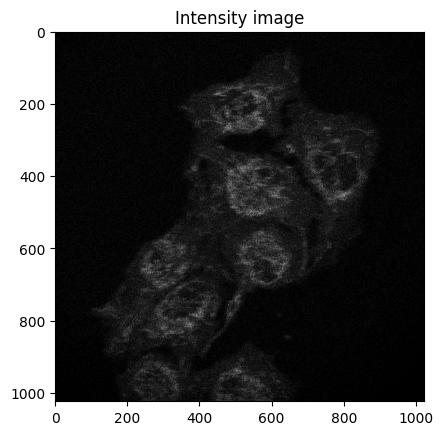

In [6]:
import matplotlib.pyplot as plt
image_slice = image.isel(frame=0,sequence=0,channel=0)

fig, ax = plt.subplots()
ax.imshow(image_slice,cmap='gray')
ax.set_title('Intensity image')
plt.show()

# bi-directional scan phase shift needs adjusting


Estimate bi-directional scan phase shift

Estimating bidirectional phase shift...
Channel overflow detected! Max channel: 50
Shift -0.0100 → score 160611.91
Channel overflow detected! Max channel: 50
Shift -0.0080 → score 162614.12
Channel overflow detected! Max channel: 50
Shift -0.0060 → score 164946.22
Channel overflow detected! Max channel: 50
Shift -0.0040 → score 172098.23
Channel overflow detected! Max channel: 50
Shift -0.0020 → score 177052.94
Channel overflow detected! Max channel: 50
Shift 0.0000 → score 183653.47
Channel overflow detected! Max channel: 50
Shift 0.0020 → score 191091.98
Channel overflow detected! Max channel: 50
Shift 0.0040 → score 205236.78
Channel overflow detected! Max channel: 50
Shift 0.0060 → score 221413.03
Channel overflow detected! Max channel: 50
Shift 0.0080 → score 219419.42
Channel overflow detected! Max channel: 50
Shift 0.0100 → score 200783.06
Best estimated shift: 0.00666


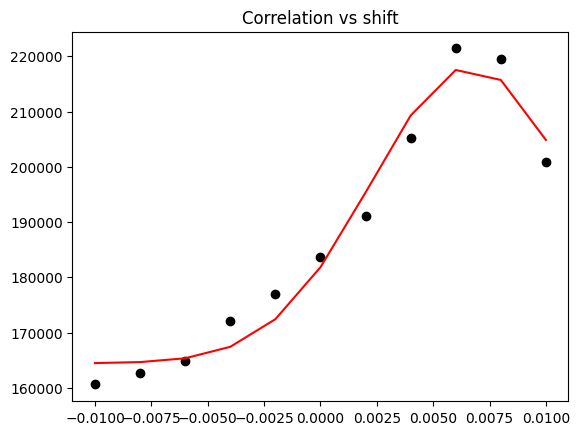

In [8]:
from flopa.io.ptuio.utils import estimate_bidirectional_shift

estimated_phase = estimate_bidirectional_shift(
        reader=reader,
        config=cfg
        )

optimized_phase_shift, scores = estimated_phase
_, ax = plt.subplots()
ax.plot(scores[0],scores[1],color='black',marker='o',linestyle='')
ax.plot(scores[0],scores[2],color='red',linestyle='-')
ax.set_title('Correlation vs shift')
plt.show()


Reconstruct FLIM image with extimated optimized shift

In [9]:
cfg.bidirectional_phase_shift = optimized_phase_shift

# For FLIM image you need both intensity and lifetime image -> specify those in outputs parameter
reconstructor = ImageReconstructor(
        config=cfg, 
        tcspc_channels= tcspc_bins + 5, # add some buffer manually
        outputs=['photon_count','mean_arrival_time']
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()


TCSPC channel overflow detected! Max channel: 24147
Channel overflow detected! Max channel: 50


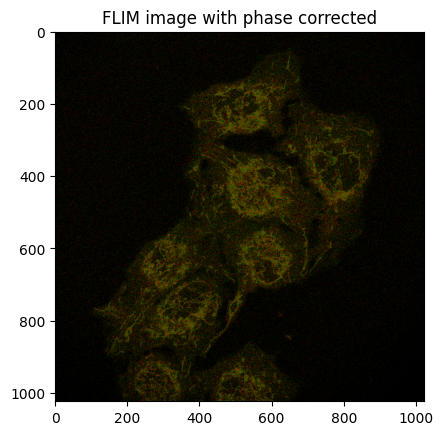

In [10]:
from flopa.io.ptuio.utils import create_FLIM_image
import matplotlib.colors as mcolors
colormap = mcolors.LinearSegmentedColormap.from_list("green_red", ["green", "red"])

FLIM_image = create_FLIM_image(mean_photon_arrival_time=result.mean_arrival_time.isel(frame=0,sequence=0,channel=0).values * tcspc_resolution * 1e9, 
                               intensity=result.photon_count.isel(frame=0,sequence=0,channel=0).values, 
                               lt_min=1, 
                               lt_max = 5,
                               int_min=0,
                               int_max=5,
                               colormap=colormap)

fig, ax = plt.subplots()
ax.imshow(FLIM_image)
ax.set_title('FLIM image with phase corrected')
plt.show()
